### Multivariate Output Stacked LSTM using Iterative Prediction

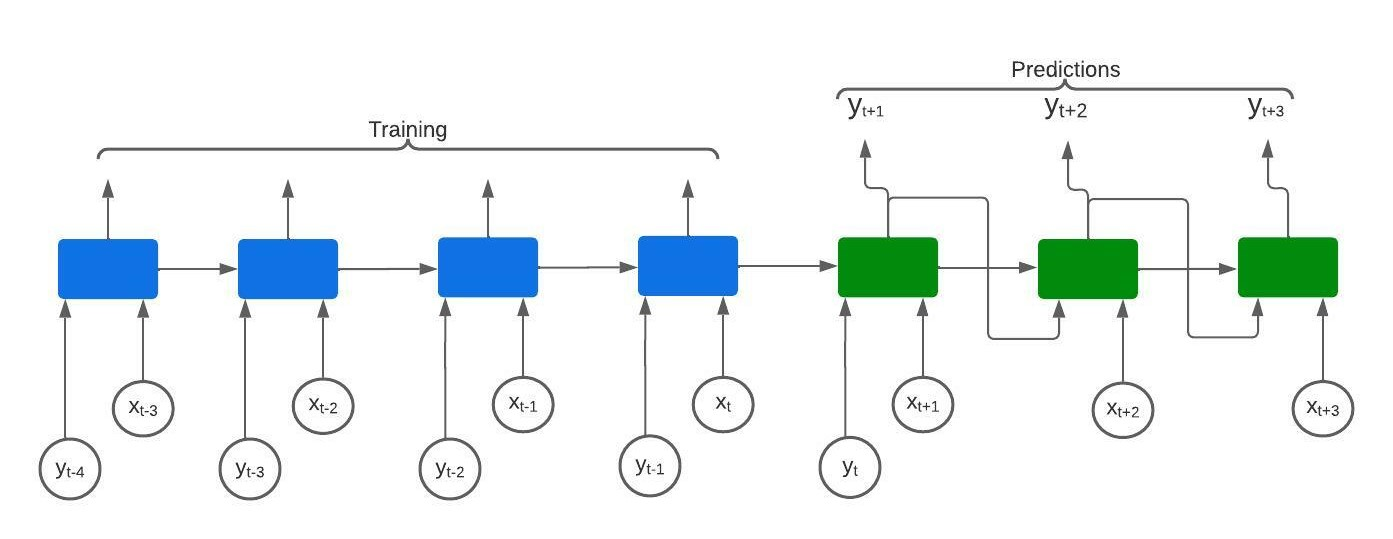

## Prediction using a standard dataset (benchmark) to investigate the usefulness of the data

Summarizing data with Pandas
- info()
- describe()
- value_counts()
- nunique()
- sum()
- count()
- min(), max(), mean(), and median()
- agg()
- groupby()

In [13]:
### I need a different dataset
sim_data = read_csv("waterTank.csv")
sim_data.describe()
# sim_data["wt3_valve"].value_counts()

,time,wt3_valve,Tank1InFlow,Tank1WaterLevel,Tank2OutFlow,Tank2WaterLevel,tank2_Tank3OutFlow,tank2.level,tank2_puddle
count,11940.000000,11940.000000,11940.000000,1.194000e+04,11940.000000,11940.000000,11940.000000,11940.000000,11940.000000
mean,298.475000,0.243635,0.501089,3.020027e+00,0.489348,2.945851,0.476949,1.427974,25.011964
std,172.346272,0.429293,0.500020,2.838824e-01,0.054100,0.279319,0.848382,0.229518,9.768620
min,0.000000,0.000000,0.000000,6.890000e-07,0.000000,0.000000,0.000000,0.000000,0.022568
25%,149.237500,0.000000,0.000000,3.057439e+00,0.499199,2.995754,0.000000,1.279368,18.432995
50%,298.475000,0.000000,1.000000,3.070966e+00,0.499715,2.998294,0.000000,1.429086,26.821231
75%,447.712500,0.000000,1.000000,3.085092e+00,0.500677,3.003658,0.000000,1.583285,33.189908
max,596.950000,1.000000,1.000000,3.102069e+00,0.501029,3.005633,2.391659,1.776479,38.476865


### Prediction with the Water Tank Simulated dataset

Initial shape of x_input (30, 5)
Value of yhat [[0.05306641 0.4360994  0.44791967 0.61591905 0.05026887]]
Value of yhat [[0.04805312 0.44491833 0.44654578 0.6115061  0.04635101]]
Value of yhat [[0.04818485 0.45234847 0.44169593 0.6095844  0.0401128 ]]
Value of yhat [[0.04981562 0.4649105  0.43422163 0.6105475  0.03634441]]
Value of yhat [[0.05187059 0.4831407  0.42153013 0.61642367 0.03546205]]
Value of yhat [[0.05438418 0.5033025  0.40373075 0.6234552  0.03603908]]
Value of yhat [[0.05688582 0.520611   0.38753468 0.6279502  0.03723537]]
Value of yhat [[0.05832564 0.533897   0.37445635 0.63294667 0.03707849]]
Value of yhat [[0.05934391 0.54418224 0.3638561  0.6353122  0.0353811 ]]
Value of yhat [[0.06007724 0.55053544 0.35312214 0.6332433  0.03194557]]
Value of yhat [[0.06117287 0.5526862  0.34301037 0.6257994  0.02650938]]
Value of yhat [[0.06211741 0.5503504  0.33461836 0.61488456 0.02160672]]
Value of yhat [[0.06311742 0.5468039  0.32547238 0.6046629  0.0179996 ]]
Value of yhat [[0.

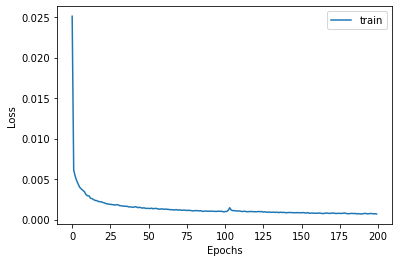

In [1]:
# multivariate output stacked lstm example
from numpy import array
from numpy import hstack, vstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers.core import Dropout
from sklearn.preprocessing import MinMaxScaler
from pandas import read_csv
from pandas import DataFrame
import matplotlib.pyplot as plt
import numpy as np


# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
# define input sequence

# Read the data
data = read_csv('pollution2.csv', header=0, index_col=0)

# horizontally stack columns
raw_data = data.values
#normalize input features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(raw_data)

n_train = 2000
#dataset = raw_data[0:n_train,:]
dataset = scaled_data[0:n_train,:]
# choose a number of time steps
n_steps = 30
# convert into input/output
X, y = split_sequences(dataset, n_steps)
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(Dropout(0.1))
model.add(LSTM(100, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(n_features))
model.compile(optimizer='adam', loss='mse')
# fit model
train_history = model.fit(X, y, epochs=200, verbose=0)

# demonstrate iterative prediction
# x_inp = raw_data[n_train:n_train+n_steps,:]
x_inp = scaled_data[n_train:n_train+n_steps,:]
print(f'Initial shape of x_input {x_inp.shape}')
# x_inp = array([[70,75,145], [80,85,165], [90,95,185]])
result = []
var_1, var_2, var_3, var_4, var_5 = list(), list(), list(), list(), list()
# num_repeat = 30
num_repeat = 30
for i in range(num_repeat):
  x_input = x_inp.reshape((1, n_steps, n_features))
  yhat = model.predict(x_input, verbose=0)
  # inv_yhat = scaler.inverse_transform(yhat)
  var_1.append(yhat[0][0])
  var_2.append(yhat[0][1])
  var_3.append(yhat[0][2])
  var_4.append(yhat[0][3])
  var_5.append(yhat[0][4])
  # p = np.append(x_inp[0],yhat[0][0])[1:]
  # q = np.append(x_inp[1],yhat[0][1])[1:]
  # r = np.append(x_inp[2],yhat[0][2])[1:]
  print(f'Value of yhat {yhat}')
  result = np.append(result,yhat[0])
  x_inp = np.append(x_inp,yhat[0])
  x_inp = x_inp.reshape(1,n_steps+1,n_features)
  x_inp = x_inp[:,1:,0:]

var = DataFrame(vstack((var_1,var_2,var_3,var_4,var_5))).T
inv_var = scaler.inverse_transform(var)
print("--------------AFTER THE INVERTED SCALING-------------------")
inv_var

print("-------Learning Curve--------")
plt.plot(train_history.history['loss'], label='train')
# plt.plot(train_history.history['val_loss'], label='test')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

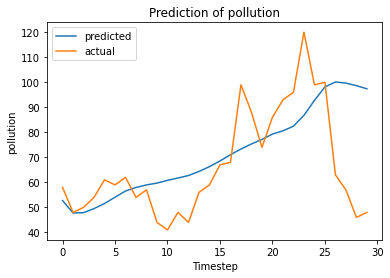

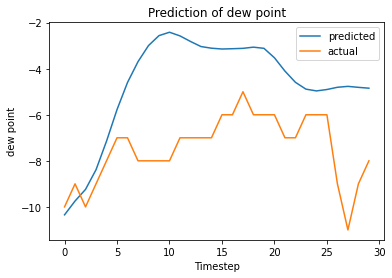

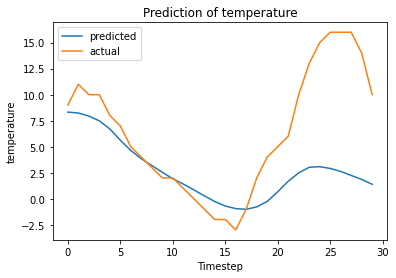

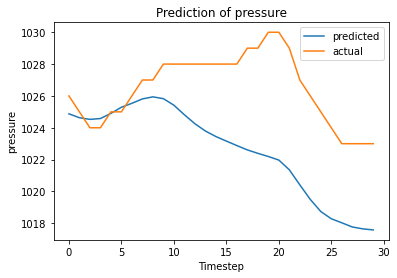

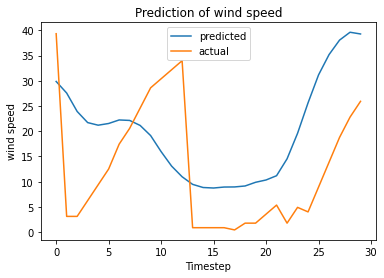

In [2]:
attr = ["pollution", "dew point", "temperature", "pressure", "wind speed"]
for i in range(5):
    title = "Prediction of "+str(attr[i])
    actual = raw_data[2030:2060,i]
    pred = inv_var.T
    plt.title(title)
    plt.xlabel("Timestep")
    plt.ylabel(attr[i])
    plt.plot(pred[i], label="predicted")
    plt.plot(actual, label="actual")
    plt.legend()
    plt.show()